<img src="./sharif.png" alt="SUT logo" width=300 height=300 align=left class="saturate">

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2024<br>
<font color=3C99D size=5>
    Practical Assignment 3<br>
<font color=696880 size=4>
    Ashkan Majidi - Shayan Salehi - Amirhossein Alamdar

____

# Personal Data

In [1]:
student_number = '99101087'
first_name = 'AmirReza'
last_name = 'Azari'

# Introduction

In this assignment, you will implement SVM (Support Vector Machines) for classification.


# Data Prepfocessing

Import your needed libraries in following cell.

In [2]:
# TODO: Write your code here
!pip install cvxopt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix

Load data from ```satimage``` dataset and split data to features and labels. The ```label``` column is our target variable. 

In [3]:
data = pd.read_csv("Data/satimage.csv") 
X = data.drop(columns=['label'])  
y = data['label']

Now split data to train, validation and test parts. 60% of data should be used for train, 15% for validation and 25% for test. After that scale the data to Standard Normal Distribution using ```StandardScaler``` class from ```scikit-learn``` library.

In [4]:
# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# X_val, X_train, y_val, y_train = train_test_split(X_temp, y_temp, test_size=0.8, random_state=42)
# or:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
print(len(X), len(X_train), len(X_val), len(X_test))

6435 3861 965 1609


We want to train Binary SVM model for classification between labels 4 and 6. Choose corresponding datas and convert their lables to 1 and -1 respectively for 4 and 6.

In [5]:
mask_train = (y_train == 4) | (y_train == 6)
mask_test = (y_test == 4) | (y_test == 6)
mask_val = (y_val == 4) | (y_val == 6)

X_train = X_train[mask_train]
X_test = X_test[mask_test]
X_val = X_val[mask_val]

y_train = y_train[mask_train]
y_test = y_test[mask_test]
y_val = y_val[mask_val]


y_train.loc[y_train == 6.0] = -1
y_train.loc[y_train == 4.0] = 1
y_test.loc[y_test == 6.0] = -1
y_test.loc[y_test == 4.0] = 1
y_val.loc[y_val == 6.0] = -1
y_val.loc[y_val == 4.0] = 1

# Model (50 points)

Here is soft margin svm convex optimization formulation. 
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2}\|\mathbf{w}\|^2+C \sum_{i=1}^N \xi_i \\
\text { Subject to } & y_i\left(\mathbf{w}^T \mathbf{x}_i+b\right) \geq 1-\xi_i, \quad i=1,2, \ldots, N \\
& \xi_i \geq 0, \quad i=1,2, \ldots, N
\end{aligned}
$$
write dual of the soft margin svm optimization problem below:

`TODO: Write Here`
## Answer:
$$Maximize \ 
 -\frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j y^i y^j \mathbf{{x}^i}^T \mathbf{x}^j + \sum_{i=1}^N \alpha_i
$$
$$
0 \leq \alpha_i \leq C, \quad \forall i = 1, 2, ..., N
$$
$$
\sum_{i=1}^N \alpha_i y^i = 0
$$


Now you should write this optimization problem in standard Quadratic Program (QP) form and use a QP solver to find optimal answer. Here is General form of a QP:
$$
\begin{aligned}
\text { Minimize } & \frac{1}{2} x^TPx + q^Tx + r \\
\text { Subject to } & Gx \leq h \\
& Ax = b
\end{aligned}
$$

Complete functions below and use ```cvxopt``` library which is a common library for solving QPs. Note that you can't use ```scikit-learn``` library.


In [6]:
def soft_margin_svm(X, y, C):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """
    
    n_samples, n_features = X.shape
    y = np.array(y).reshape(-1, 1)

    K = np.dot(X, X.T)
    P = matrix((np.outer(y, y) * K).astype(float))
    q = matrix((-np.ones((n_samples, 1))).astype(float))
    G = matrix((np.vstack((np.eye(n_samples) * (-1), np.eye(n_samples)))).astype(float))
    h = matrix((np.hstack((np.zeros(n_samples), np.ones(n_samples) * C))).astype(float))
    A = matrix((y.reshape(1, -1)).astype(float))
    b = matrix(np.array([0.0]))

    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x'])
    sv = (alphas > 1e-4).flatten()

    support_vectors = X[sv]
    support_vector_labels = y[sv]
    support_vector_alphas = alphas[sv]

    return support_vectors, support_vector_labels, support_vector_alphas

In [7]:
C = 1.0
support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C)

     pcost       dcost       gap    pres   dres
 0: -6.1265e+02 -3.3971e+03  2e+04  3e+00  2e-13
 1: -4.1824e+02 -2.2816e+03  3e+03  3e-01  1e-13
 2: -3.9732e+02 -7.6474e+02  4e+02  3e-02  8e-14
 3: -4.4111e+02 -5.8227e+02  2e+02  9e-03  8e-14
 4: -4.6125e+02 -5.3708e+02  8e+01  4e-03  8e-14
 5: -4.7293e+02 -5.1305e+02  4e+01  2e-03  8e-14
 6: -4.7763e+02 -5.0407e+02  3e+01  1e-03  8e-14
 7: -4.8272e+02 -4.9477e+02  1e+01  4e-04  8e-14
 8: -4.8534e+02 -4.9054e+02  5e+00  2e-04  9e-14
 9: -4.8671e+02 -4.8840e+02  2e+00  4e-05  9e-14
10: -4.8718e+02 -4.8773e+02  6e-01  7e-06  9e-14
11: -4.8738e+02 -4.8747e+02  9e-02  4e-07  9e-14
12: -4.8742e+02 -4.8743e+02  7e-03  3e-08  1e-13
13: -4.8742e+02 -4.8742e+02  2e-04  6e-10  1e-13
Optimal solution found.


In [8]:
def predict_labels(x_test, support_vectors, support_vector_labels, support_vector_alphas):
    """
    input:
        x_test: test data
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    output:
        y_pred: predictoin labels
    """
    
    y_pred = []

    for x in x_test:
        prediction = 0
        for sv, sv_lab, sv_alpha in zip(support_vectors, support_vector_labels, support_vector_alphas):
            prediction += sv_alpha * sv_lab * np.dot(sv, x)
        y_pred.append(np.sign(prediction))
        
    return y_pred

In [9]:
y_pred = predict_labels(np.array(X_test), support_vectors, support_vector_labels, support_vector_alphas)
print(y_pred)

[array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([1.]), array([1.]), array([-1.]), array([-1.]), array([1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([-1.]), array([1.]), array([-1.]), array([-1.]), array([-1.]), array([

# Evaluation (20 points)

Compute accuracy, balanced accuracy and plot confusion matrix of your trained model using ```Seaborn.heatmap()``` function. Use case of balanced accuracy is when dealing with imbalanced data, i.e. when one of the target classes appears a lot more than the other and it is defined by average of recall of classes. Confusion matrix is a $k\times k$ (k is number of classes) matrix which cell ij is showing that number of data points labeld i which predicted j. For more detail of evaluation metrics you can see [here](https://neptune.ai/blog/balanced-accuracy).

You may use ```scikit-learn``` library to compute these metrics.

In [10]:
def evaluate(y_test, y_pred):
    """
    input:
        y_test: true labels
        y_pred: predicted labels
    output:
        accuracy: accuracy of the model
        balanced_accuracy: balanced accuracy of the model
        confusion_matrix: confusion matrix of the model
    """
    # TODO: Write your code here

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)

    print("Accuracy: ", accuracy)
    print("Balanced Accuracy: ", balanced_accuracy)
    print("Confusion Matrix:\n", confusion_mat)
    
    return accuracy, balanced_accuracy, confusion_mat


_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8252788104089219
Balanced Accuracy:  0.7639855133496167
Confusion Matrix:
 [[348  35]
 [ 59  96]]


<Axes: >

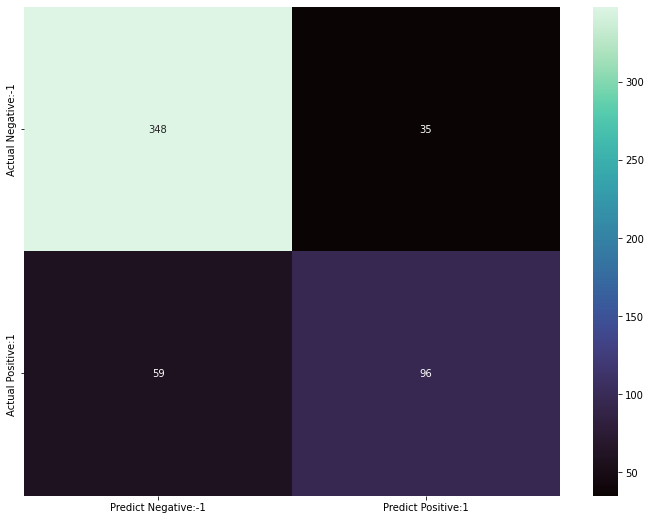

In [11]:
plt.figure(figsize=(12, 9))
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predict Negative:-1', 'Predict Positive:1'],
                                 index=['Actual Negative:-1', 'Actual Positive:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Fine-tunning (40 points)

like what you did before, implement Soft Margin SVM but now use rbf kernel. To determine rbf $\gamma$ parameter use validation datas and find best(best by balanced accuracy) $\gamma$ between 0.001 , 0.01, 1, 10, 100. Not that you can't use ```scikit-learn``` library here.

In [12]:
def rbf(x1, x2, gamma=1):
    """
    input:
        x1: first vector
        x2: second vector
        gamma: rbf kernel parameter with defalt value 1.
    output:
        ouput: computed rbf of two input vectors
    """
    # TODO: Write your code here
    output = np.exp(-np.sum((x1-x2) ** 2) / (2 * gamma**2))
    return output
#     output = np.exp(-gamma * np.dot((x1 - x2), (x1 - x2)))
#     return output

def soft_margin_svm(X, y, C, gamma=1):
    """
    input:
        X: training data
        y: training labels
        C: errors weight
        gamma: rbf kernel parameter with defalt value 1.
    output:
        support_vectros: data points which are SVs of our model.
        support_vector_labels: labels of SVs
        support_vector_alphas: alpha coefficient of corresponding SVs 
    """

    n_samples, n_features = X.shape
    
    K = np.zeros((n_samples, n_samples))
    
    for i in range(n_samples):
        for j in range(i, n_samples):
            K[i, j] = rbf(X[i], X[j], gamma)
            K[j, i] = K[i, j] 

    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(solution['x']).flatten()
    support_vector_indices = alphas > 1e-5
    support_vectors = X[support_vector_indices]
    support_vector_labels = y[support_vector_indices]
    support_vector_alphas = alphas[support_vector_indices]
    
    return support_vectors, support_vector_labels, support_vector_alphas

In [13]:
gammas = [0.01, 0.1, 1, 10, 100]
best_gamma = None
best_support_vectors = None
best_support_vector_labels = None
best_support_vector_alphas = None

best_balanced_accuracy = 0
for gamma in gammas:
    print("gamma = ", gamma)
    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, y_train, C, gamma)
    
    y_pred = predict_labels(X_val, support_vectors, support_vector_labels, support_vector_alphas)
    
    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    
    if balanced_accuracy > best_balanced_accuracy:
        best_gamma = gamma
        best_support_vectors = support_vectors
        best_support_vector_labels = support_vector_labels
        best_support_vector_alphas = support_vector_alphas
        best_balanced_accuracy = balanced_accuracy

print("best gamma:",best_gamma)

gamma =  0.01
     pcost       dcost       gap    pres   dres
 0: -4.6331e+02 -2.1253e+03  2e+03  4e-13  5e-16
 1: -4.6978e+02 -5.0577e+02  4e+01  4e-14  1e-16
 2: -4.7552e+02 -4.7591e+02  4e-01  1e-13  7e-17
 3: -4.7559e+02 -4.7559e+02  4e-03  9e-14  1e-16
 4: -4.7559e+02 -4.7559e+02  4e-05  3e-13  2e-17
Optimal solution found.
gamma =  0.1
     pcost       dcost       gap    pres   dres
 0: -4.6331e+02 -2.1253e+03  2e+03  2e-13  3e-16
 1: -4.6978e+02 -5.0577e+02  4e+01  7e-14  3e-16
 2: -4.7552e+02 -4.7591e+02  4e-01  2e-13  4e-17
 3: -4.7559e+02 -4.7559e+02  4e-03  3e-13  1e-16
 4: -4.7559e+02 -4.7559e+02  4e-05  4e-13  7e-17
Optimal solution found.
gamma =  1
     pcost       dcost       gap    pres   dres
 0: -2.2807e+02 -2.3860e+03  1e+04  2e+00  2e-15
 1: -1.9511e+02 -1.3394e+03  1e+03  1e-01  9e-16
 2: -2.1236e+02 -4.1488e+02  2e+02  2e-02  1e-15
 3: -2.3269e+02 -2.8889e+02  6e+01  3e-03  1e-15
 4: -2.4128e+02 -2.5379e+02  1e+01  2e-04  9e-16
 5: -2.4336e+02 -2.4664e+02  3e+00 

In [14]:
y_pred = predict_labels(np.array(X_test), best_support_vectors, best_support_vector_labels, best_support_vector_alphas)
_, _, confusion_mat = evaluate(y_test, y_pred)

Accuracy:  0.8085501858736059
Balanced Accuracy:  0.7426345489766697
Confusion Matrix:
 [[344  39]
 [ 64  91]]


# Multiclass SVM (30 points + 50 points optional)

Now we want implement Multiclass SVM. Use ```SVC``` function with rbf kernel from ```scikit-learn``` package on all train datas (all six classes) and choose best hyperparameters for $C$ and $\gamma$ between 0.01, 0.1, 1, 10, 100. After that evaluate it with your function.

Note that in this example we had enough data to split them in train and validation but in case that we don't have enough data, ```scikit-learn``` has a built-in fast library named ```GridSearchCV()``` which can help us in hyperparameter tunning with cross validation.

Best C : 10
Best gamma : 0.1
Accuracy:  0.8819142324425109
Balanced Accuracy:  0.8689104585701625
Confusion Matrix:
 [[345   1   5   1   3   0]
 [  0 182   0   1   3   3]
 [  3   2 305  25   1   6]
 [  1   1  23 106   4  20]
 [ 10   5   0   1 160   9]
 [  0   1   9  44   8 321]]


<Axes: >

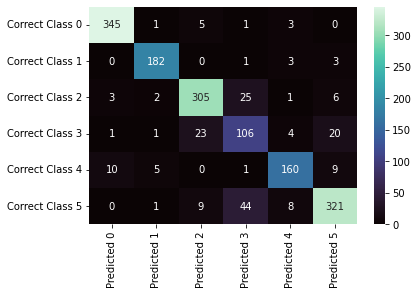

In [15]:
# Helped from GPT

Cs = [0.01, 0.1, 1, 10, 100]
gammas = [0.01, 0.1, 1, 10, 100]

# loading data with all classes
data = pd.read_csv('./Data/satimage.csv')
X = data.drop('label', axis=1)
y = data['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.625, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

parameter_grid = {'C':Cs, 'gamma': gammas}
svm_model = SVC(kernel='rbf')

grid_search = GridSearchCV(estimator = svm_model, param_grid = parameter_grid, cv = 5, scoring ='balanced_accuracy')
grid_search.fit(X_val, y_val)

best_C = grid_search.best_params_['C']
print(f"Best C : {best_C}")
best_gamma = grid_search.best_params_['gamma']
print(f"Best gamma : {best_gamma}")
best_model = grid_search.best_estimator_


y_pred = best_model.predict(X_test)
_, _, confusion_mat = evaluate(y_test, y_pred)
num_classes = 6
cm_matrix = pd.DataFrame(data=confusion_mat, columns=['Predicted ' + str(i) for i in range(num_classes)],
                                index=['Correct Class ' + str(i) for i in range(num_classes)])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

Implement Multiclass SVM from scratch without using ready functions (optional).

     pcost       dcost       gap    pres   dres
 0:  1.0455e-10 -3.8610e+04  8e+04  1e-01  6e-17
 1:  1.5228e-12 -7.0470e+02  1e+03  1e-03  1e-16
 2:  1.4961e-14 -7.0477e+00  1e+01  1e-05  5e-16
 3:  1.4957e-16 -7.0477e-02  1e-01  1e-07  3e-16
 4:  1.4958e-18 -7.0477e-04  1e-03  1e-09  2e-15
 5:  1.4958e-20 -7.0477e-06  1e-05  1e-11  2e-15
 6:  1.4958e-22 -7.0477e-08  1e-07  1e-13  2e-15
 7:  1.4958e-24 -7.0477e-10  1e-09  1e-15  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  8.7168e+03 -9.3162e+04  1e+05  1e-11  9e-16
 1:  1.6768e+03 -1.1757e+04  1e+04  9e-12  6e-16
 2: -1.2438e+03 -2.8217e+03  2e+03  8e-12  2e-16
 3: -1.4252e+03 -1.5154e+03  9e+01  6e-14  1e-16
 4: -1.4264e+03 -1.4274e+03  1e+00  1e-13  5e-17
 5: -1.4264e+03 -1.4264e+03  1e-02  4e-13  6e-17
 6: -1.4264e+03 -1.4264e+03  1e-04  3e-13  6e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.4790e+03 -7.2145e+04  8e+04  4e-11  2e-15
 1:  1.5206e+03 -1.0689e

C:\Users\Amir Reza 81\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


<Axes: >

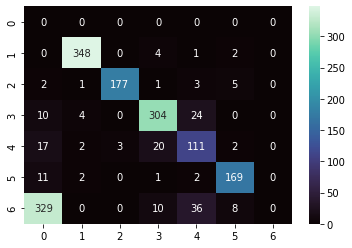

In [16]:
# Helped from net and GPT
# use One vs All architecture

def predict_multi_class(x_test, classifiers):
    num_classes = len(classifiers)
    num_samples = len(x_test)
    predictions = np.zeros((num_samples, num_classes))

    for i, (support_vectors, support_vector_labels, support_vector_alphas) in enumerate(classifiers):
        for j in range(num_samples):
            prediction = 0
            for alpha, labell, sv in zip(support_vector_alphas, support_vector_labels, support_vectors):
                prediction += alpha * labell * rbf(x_test[j], sv, best_gamma)
            predictions[j, i] = prediction

    y_pred = np.argmax(predictions, axis=1)
    return y_pred

classifiers = []
num_classes = 6
for class_label in range(num_classes):
    binary_labels = np.where(y_train == class_label, 1, -1)

    support_vectors, support_vector_labels, support_vector_alphas = soft_margin_svm(X_train, binary_labels,
                                                                                    best_C, best_gamma)
    classifiers.append((support_vectors, support_vector_labels, support_vector_alphas))


y_pred = predict_multi_class(X_test, classifiers)
_, _, confusion_mat = evaluate(y_test, y_pred)

cm_matrix = pd.DataFrame(data=confusion_mat)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='mako')

# Different SVM Kernels (40 points)

A kernel in SVM is like a tool that helps solve tricky problems. It lets us work in a space with many dimensions, making complex calculations easier. With kernels, we can deal with lots of dimensions, even an endless amount. Kernels are crucial for sorting data into groups and help spot patterns in the data we're looking at. They're especially good at tackling twisty problems with a straightforward approach.

Sometimes, finding a straight line or flat surface to divide data isn't possible, especially as we explore more dimensions. That's where different types of SVM kernels come in handy. They transform twisty, complicated data into a simpler form that's easier to separate. In this explanation, we talk about 4 popular types of these kernels. Also in following cells you can use any package.

<img src="./kernel.jpg" alt="Types of Kernel Functions"  align=center class="saturate">

### Linear Kernel

This is the simplest kind of kernel, typically working in one dimension. It works best when dealing with a lot of features. Linear kernels are quicker than other types.

**Formula:**

$$F(x, x_j) = sum(x, x_j)$$

Now Implement svc classifier using a linear kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix by `Seaborn`.

Accuracy:  0.872591671845867
Balanced Accuracy:  0.8344319384555986
Confusion Matrix:
 [[351   0   1   0   3   0]
 [  1 173   1   0  14   0]
 [  3   0 322  15   1   1]
 [  4   1  37  72   3  38]
 [  5   7   0   2 153  18]
 [  0   0  11  27  12 333]]


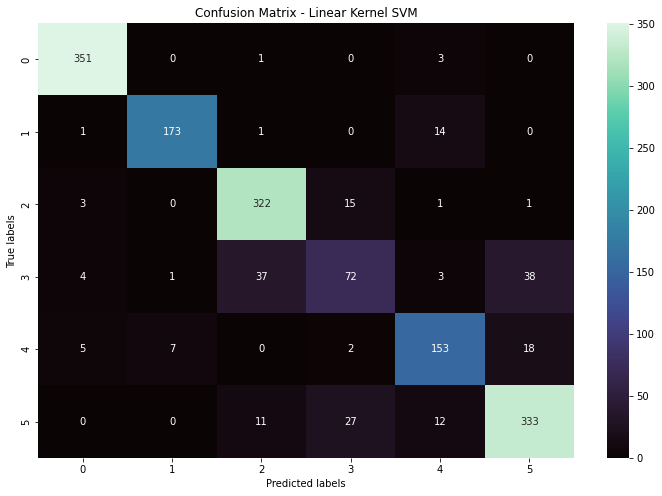

In [17]:
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train, y_train)

y_pred_linear = svc_linear.predict(X_test)

accuracy_linear, balanced_accuracy_linear, confusion_mat_linear = evaluate(y_test, y_pred_linear)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat_linear, annot=True, cmap='mako', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Linear Kernel SVM')
plt.show()

### Gaussian RBF kernel

This kernel is a favorite choice in SVM, especially for data that doesn't line up straight. It's great for sorting data when you don't know much about it beforehand.

**Formula:**

$$F(x, x_j) = \exp{(-\gamma ||x - xj||^2)}$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous part. 

Accuracy:  0.8912367930391547
Balanced Accuracy:  0.8678617390048845
Confusion Matrix:
 [[351   1   2   0   1   0]
 [  0 181   0   1   6   1]
 [  3   1 325   7   1   5]
 [  3   1  37  90   2  22]
 [  3   2   1   1 164  14]
 [  0   1  11  41   7 323]]


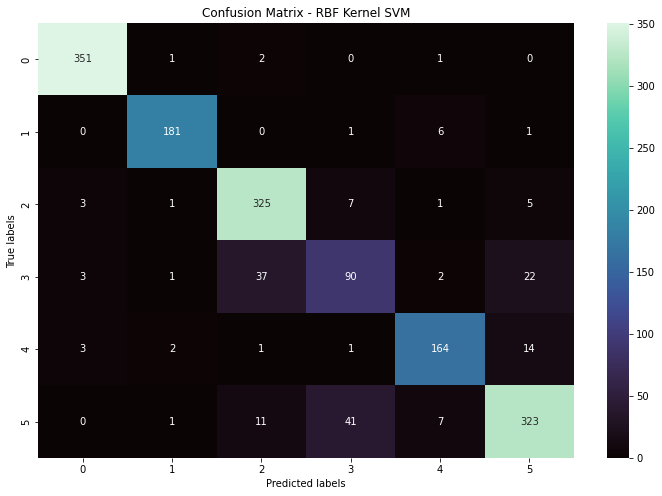

In [18]:
svc_rbf = SVC(kernel='rbf')
svc_rbf.fit(X_train, y_train)
y_pred_rbf = svc_rbf.predict(X_test)

accuracy_rbf, balanced_accuracy_rbf, confusion_mat_rbf = evaluate(y_test, y_pred_rbf)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat_rbf, annot=True, cmap='mako', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - RBF Kernel SVM')
plt.show()

### Polynomial Kernel

This is a broader version of the linear kernel. It's not as popular because it's not as quick or precise.

**Formula:**

$$F(x, x_j) = (x.x_j+1)^d$$

Now, set up the SVC classifier using a *polynomial* kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts.

Accuracy:  0.8477315102548166
Balanced Accuracy:  0.8191602351764184
Confusion Matrix:
 [[353   0   1   0   1   0]
 [  3 175   1   3   5   2]
 [  5   0 310  21   0   6]
 [ 11   0  30  93   0  21]
 [ 25   2   0  10 128  20]
 [  2   1   4  68   3 305]]


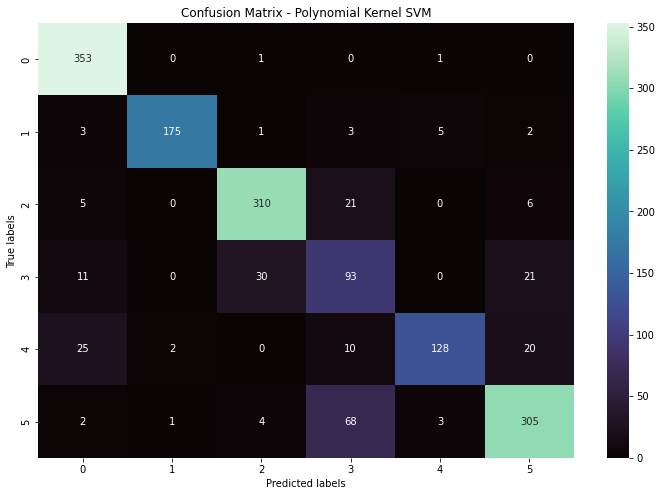

In [19]:
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train, y_train)
y_pred_poly = svc_poly.predict(X_test)

accuracy_poly, balanced_accuracy_poly, confusion_mat_poly = evaluate(y_test, y_pred_poly)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat_poly, annot=True, cmap='mako', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Polynomial Kernel SVM')
plt.show()

### Sigmoid Kernel

This is mainly chosen for use with neural networks. The kernel function acts like the activation function in a two-layer perceptron neural network model, helping to activate the neurons.

**Formula:**

$$F(x, x_j) = \tanh(α x a y + c)$$

Now, configure the SVC classifier with a sigmoid kernel. Get the prediction and evaluate it by function which you implemented before. Also plot confusion matrix as previous parts. 

Accuracy:  0.723430702299565
Balanced Accuracy:  0.678944902894234
Confusion Matrix:
 [[293   5  16   0  41   0]
 [ 25 156   0   2   6   0]
 [  2   0 306  30   3   1]
 [  4   1  39  50  16  45]
 [ 21  28   6  27  96   7]
 [  0   1  11  53  55 263]]


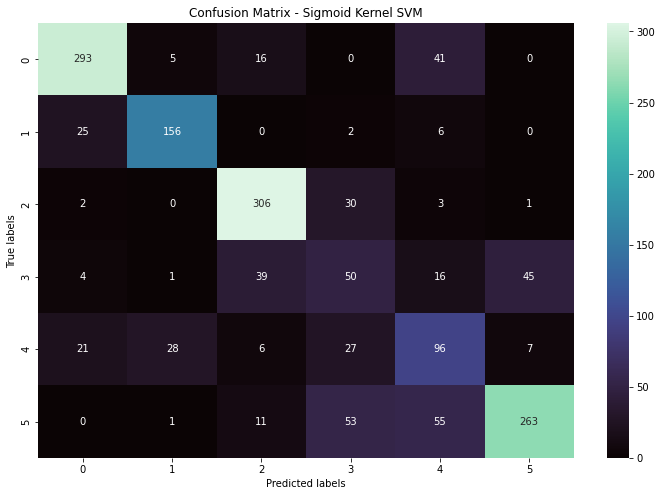

In [20]:
svc_sigmoid = SVC(kernel='sigmoid')
svc_sigmoid.fit(X_train, y_train)
y_pred_sigmoid = svc_sigmoid.predict(X_test)

accuracy_sigmoid, balanced_accuracy_sigmoid, confusion_mat_sigmoid = evaluate(y_test, y_pred_sigmoid)
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat_sigmoid, annot=True, cmap='mako', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Sigmoid Kernel SVM')
plt.show()

Compare these four kernel functions with each other. What are the main advantages and disadvantages of each one? 

`TODO: Linear kernels are commended for simplicity and computational efficiency, particularly effective for linearly separable data, but they struggle with complex patterns and non-linear relationships. Gaussian RBF kernels excel in handling non-linearly separable data by mapping features to high-dimensional spaces but require careful tuning of parameters like gamma to prevent overfitting and can be computationally expensive. Polynomial kernels offer flexibility in capturing non-linear relationships but demand parameter tuning and are prone to overfitting with high-degree polynomials.

Sigmoid kernels, while capable of capturing non-linear relationships, are less commonly used due to challenges in parameter tuning and less understanding of their distribution. Additionally, the texts highlight the importance of considering factors like computational efficiency, data distribution understanding, and sensitivity to parameter choices when selecting an appropriate kernel for a given machine learning task.`

```
1. Linear Kernel:
   - Avantages:
       .Easy to understand and implement.
       .Computationally less intensive than other kernels.
       .Works well when data exhibits linear relationships.
   - Disadvantages:
       .Limited Complexity
       .Performs poorly with non-linearly separable data.

2. Gaussian RBF Kernel:
   - Avantages:
       .Can handle non-linearly separable data effectively.
       .Capable of capturing non-linear relationships by mapping features to high-dimensional spaces.
       .Offers flexibility in the decision boundary, focusing more on individual data points.
   - Disadvantages:
       .Computational Expense
       .Overfitting
       
3. Polynomial Kernel:
   - Avantages:
       .Flexibility
       .Implicitly includes combinations of features up to a certain degree, providing a thorough analysis of feature interactions.
   - Disadvantages:
       .Computational Intensity
       .Higher-degree polynomials can lead to overfitting, especially if the degree parameter is too high.
       
4. Sigmoid Kernel:
   - Avantages:
       .Resembles the behavior of neurons in neural networks, beneficial for certain types of problems.
       .Can be used as a proxy for neural networks in SVMs, providing a balance between linear and non-linear properties.
   - Disadvantages:
       .Finding the right parameters can be challenging, leading to optimization problems.
       .Less Commonly Used
```